### Student Name: **HARIKA RAVI**
### Student Number: ***9032698***
### **LAB-03 CNN & VGG16 FOR DOGS v/s CATS**
---------------------------

#### **Loading the Dataset**

In [ ]:
import os, shutil, pathlib

# Path to the original dataset containing all the images
original_dir = pathlib.Path(r"C:\Users\harik\OneDrive\Documents\GitHub\CNN fine tune for Cats and Dogs\Cats Vs Dogs\train\train")
# Path to the new base directory where the subsets will be created
new_base_dir = pathlib.Path(r"C:\Users\harik\OneDrive\Documents\GitHub\CNN fine tune for Cats and Dogs\Kaggle_cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        # Generate the filenames for the specified range of images
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,   # Source file path
                            dst=dir / fname) # Destination file path

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### **EDA (Explore the Data)**

#### **Insights:**
* ***Balanced Dataset:***
The dataset is well-balanced, with an equal number of cat and dog images across all subsets (train, validation, and test). This ensures that the model will not be biased towards one category.

File Distribution by Subset and Category:
Train: Cats - 1000, Dogs - 1000
Validation: Cats - 500, Dogs - 500
Test: Cats - 1000, Dogs - 1000


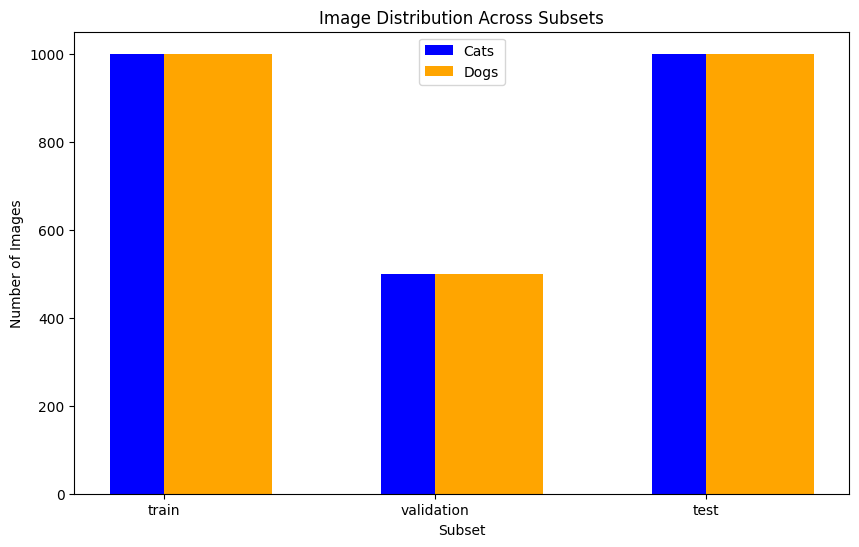

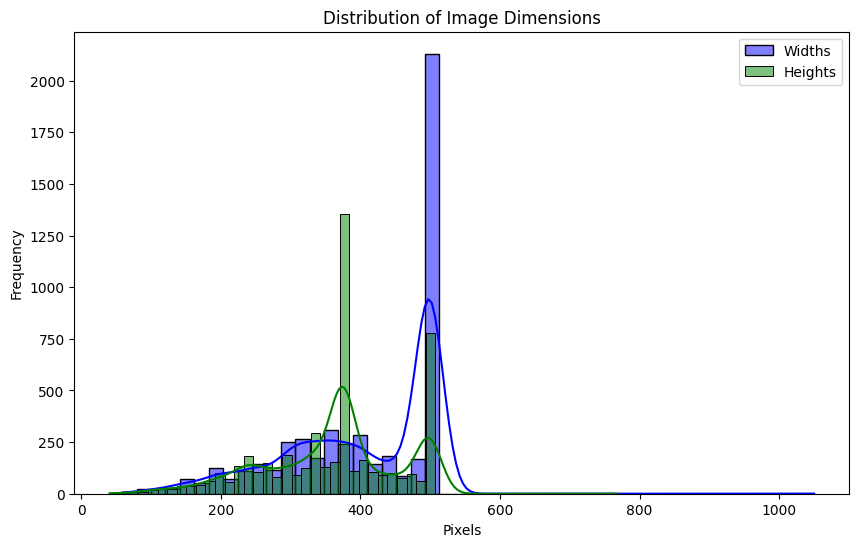


Image Dimension Statistics:
Widths - Min: 59, Max: 1050, Mean: 403.88
Heights - Min: 41, Max: 768, Mean: 360.56


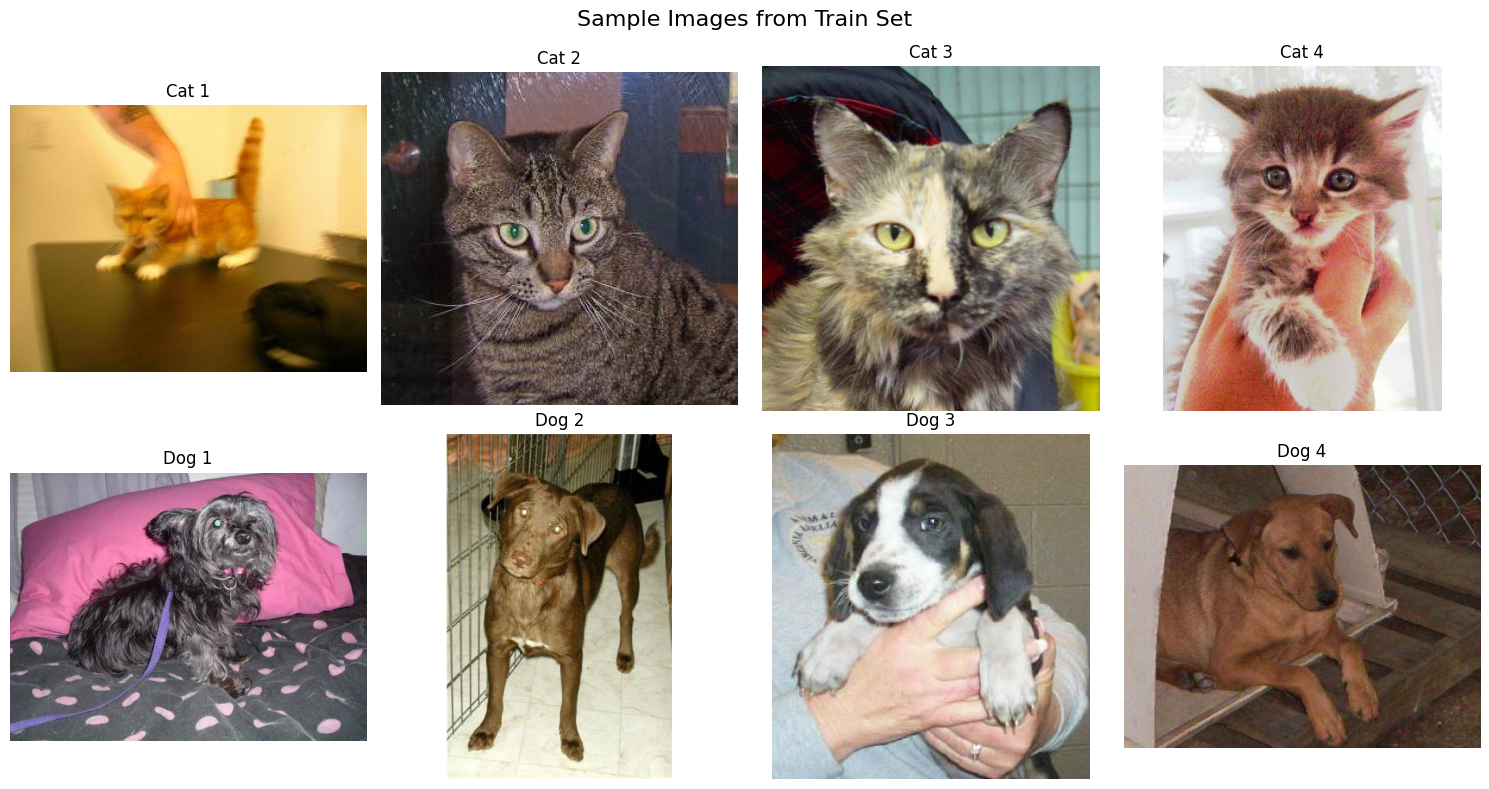


Insights:
1. The dataset is balanced, as the number of cat and dog images are equal in each subset.
2. Image dimensions vary, with most widths and heights clustering around specific values.
3. The train set has sufficient data (2000 images) for model training, while validation and test sets are appropriately smaller.


In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from collections import Counter

# Define base directory for the subsets
base_dir = Path(r"C:\Users\harik\OneDrive\Documents\GitHub\CNN fine tune for Cats and Dogs\Kaggle_cats_vs_dogs_small")

# Function to count files in each subset and category
def count_files(base_dir):
    stats = {}
    for subset in ['train', 'validation', 'test']:
        subset_dir = base_dir / subset
        category_counts = {}
        for category in ['cat', 'dog']:
            category_dir = subset_dir / category
            category_counts[category] = len(os.listdir(category_dir)) if category_dir.exists() else 0
        stats[subset] = category_counts
    return stats

# Function to get image dimensions
def get_image_dimensions(base_dir):
    dimensions = []
    for subset in ['train', 'validation', 'test']:
        subset_dir = base_dir / subset
        for category in ['cat', 'dog']:
            category_dir = subset_dir / category
            if category_dir.exists():
                for img_file in os.listdir(category_dir):
                    img_path = category_dir / img_file
                    try:
                        with Image.open(img_path) as img:
                            dimensions.append(img.size)
                    except Exception as e:
                        print(f"Error with image {img_path}: {e}")
    return dimensions

# Function to display sample images
def display_sample_images(base_dir, subset, n=4):
    subset_dir = base_dir / subset
    fig, axes = plt.subplots(2, n, figsize=(15, 8))
    for i, category in enumerate(['cat', 'dog']):
        category_dir = subset_dir / category
        images = os.listdir(category_dir)[:n]
        for j, img_file in enumerate(images):
            img_path = category_dir / img_file
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{category.capitalize()} {j+1}")
    plt.suptitle(f"Sample Images from {subset.capitalize()} Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run EDA
stats = count_files(base_dir)
print("File Distribution by Subset and Category:")
for subset, counts in stats.items():
    print(f"{subset.capitalize()}: Cats - {counts['cat']}, Dogs - {counts['dog']}")

# Plot distribution
subsets = stats.keys()
cats = [stats[subset]['cat'] for subset in subsets]
dogs = [stats[subset]['dog'] for subset in subsets]
x = range(len(subsets))

plt.figure(figsize=(10, 6))
plt.bar(x, cats, width=0.4, label='Cats', align='center', color='blue')
plt.bar(x, dogs, width=0.4, label='Dogs', align='edge', color='orange')
plt.xticks(x, subsets)
plt.xlabel('Subset')
plt.ylabel('Number of Images')
plt.title('Image Distribution Across Subsets')
plt.legend()
plt.show()

# Analyze image dimensions
dimensions = get_image_dimensions(base_dir)
widths, heights = zip(*dimensions)

# Plot image dimensions
plt.figure(figsize=(10, 6))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="green", label="Heights")
plt.title("Distribution of Image Dimensions")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Display summary statistics
print("\nImage Dimension Statistics:")
print(f"Widths - Min: {np.min(widths)}, Max: {np.max(widths)}, Mean: {np.mean(widths):.2f}")
print(f"Heights - Min: {np.min(heights)}, Max: {np.max(heights)}, Mean: {np.mean(heights):.2f}")

# Display sample images from the train set
display_sample_images(base_dir, subset='train', n=4)

# Insights
print("\nInsights:")
print("1. The dataset is balanced, as the number of cat and dog images are equal in each subset.")
print("2. Image dimensions vary, with most widths and heights clustering around specific values.")
print("3. The train set has sufficient data (2000 images) for model training, while validation and test sets are appropriately smaller.")


### **Conclusions:**
1. ***Data Preparation:***
The data preparation steps, such as creating subsets and counting files, are essential for ensuring the dataset is organized and ready for model training.

2. ***Exploratory Data Analysis (EDA):***
Conducting EDA, like plotting the distribution of image counts and analyzing image dimensions, provides valuable insights into the dataset. This helps in making informed decisions about data augmentation, model architecture, and preprocessing steps.
----------------------------------------------------------------------

### **Training a CNN for a real-world Image Classification Task**

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

##### **Load the data into three sets:** 

In [20]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path(r"C:\Users\harik\OneDrive\Documents\GitHub\CNN fine tune for Cats and Dogs\Kaggle_cats_vs_dogs_small")

In [21]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### **Definning the model**

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 432ms/step - accuracy: 0.4996 - loss: 0.7000 - val_accuracy: 0.5030 - val_loss: 0.6919
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step - accuracy: 0.5290 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.5590 - loss: 0.6848 - val_accuracy: 0.6050 - val_loss: 0.6555
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 360ms/step - accuracy: 0.6136 - loss: 0.6467 - val_accuracy: 0.6710 - val_loss: 0.6055
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.6579 - loss: 0.6098 - val_accuracy: 0.6530 - val_loss: 0.5994
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.6775 - loss: 0.5845 - val_accuracy: 0.6760 - val_loss: 0.5805
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.7201 - loss: 0.5553 - val_accuracy: 0.6760 - val_loss: 0.6026
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7343 - loss: 0.5190 - val_accu

####  **Model Training**

#### **Explore the relative performance of the models**

### ***1. ACCURACY***

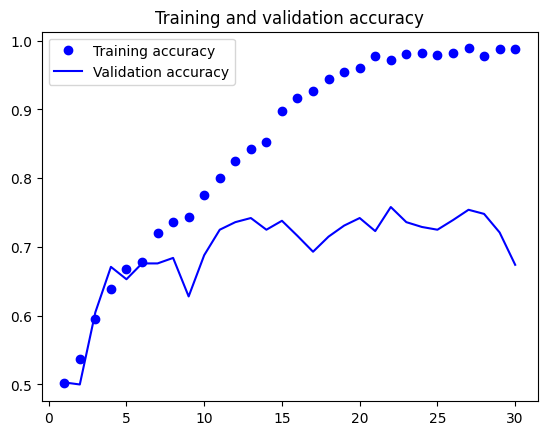

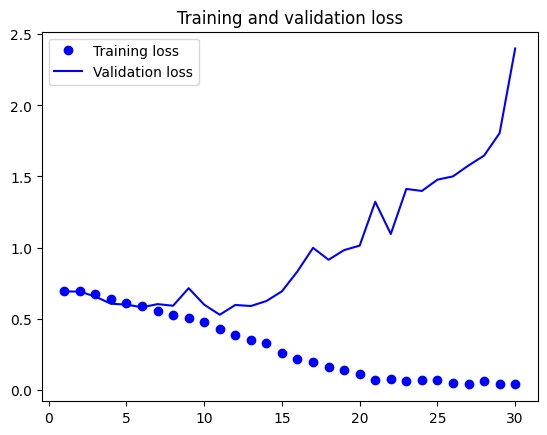

In [26]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve
import numpy as np
import tensorflow as tf

# Load the best model
best_model = keras.models.load_model("./models/convnet_from_scratch.keras")

# Evaluate on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate predictions on the test dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_prob = best_model.predict(test_dataset)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.7195 - loss: 0.5875
Test Loss: 0.5710, Test Accuracy: 0.7250
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


#### **Conclusion:**
1. ***Training and Validation Accuracy:***
The training accuracy increases steadily over the epochs, indicating that the model is learning and fitting the training data well.
The validation accuracy improves initially but may plateau or fluctuate after a few epochs. This suggests that the model is nearing its performance limit on unseen data and might require fine-tuning or regularization if overfitting occurs.

2. ***Training and Validation Loss:*** 
The training loss decreases consistently, demonstrating that the model minimizes the error on the training set.
The validation loss may start decreasing but could plateau or increase after a certain point. An increasing validation loss while training loss continues to decrease indicates potential overfitting, where the model performs well on training data but struggles to generalize to unseen data.
* If the gap between training and validation accuracy widens significantly or the validation loss starts increasing, the model might be overfitting.
* A small gap between training and validation performance suggests a good generalization ability of the model.

### ***2. CONFUSION METRIX***

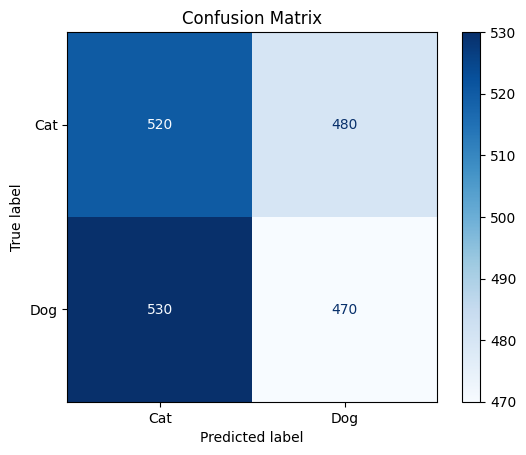

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### **Conclusion**
* The confusion matrix helps identify class-specific performance issues, such as whether the model struggles more with cats or dogs.
* If one class has significantly more misclassifications, it could indicate an imbalance in the data or class-specific challenges in distinguishing features.

### ***3. PRECISION, RECALL, F1-score, Precision-Recall Curve***


Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.52      0.51      1000
         Dog       0.49      0.47      0.48      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



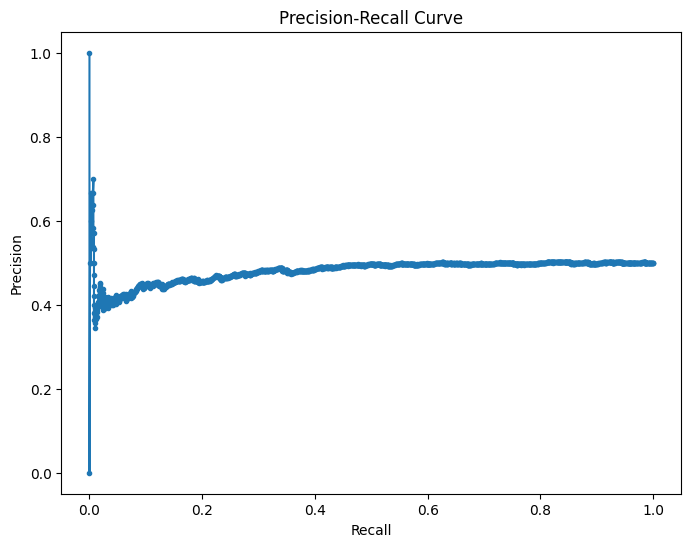

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Cat", "Dog"])
print("\nClassification Report:")
print(report)

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


#### **Conclusion:**
***1.Precision:*** 
The proportion of correctly predicted positive instances (e.g., dogs) out of all predicted positive instances. High precision means fewer false positives.
* **0.50** indicates that half of the instances predicted as **"Cat"** are correct.
* **0.49**, meaning less than half of the **"Dog"** predictions are correct.

***2.Recall (Sensitivity):*** 
The proportion of correctly predicted positive instances out of all actual positive instances. High recall indicates fewer false negatives.
* **0.52** means that 52% of actual **"Cat"** instances are correctly identified.
* **0.47**, showing that only 47% of actual **"Dog"** instances are correctly identified.

***3.F1-Score:*** The harmonic mean of precision and recall, balancing the two metrics
* The F1-score for both classes is around **0.48 - 0.51**, which further emphasizes the model's lack of effectiveness in this classification task.

***4.Precision-Recall Curve:*** This curve illustrates the trade-off between precision and recall at various thresholds for classification.
* The precision-recall curve provides a visual representation of the trade-off between precision and recall at various threshold levels. However, given the low classification performance, this curve is likely not very informative.

### ***4. Explore specific examples in which the model failed to predict correctly***

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of misclassifications: 2000000


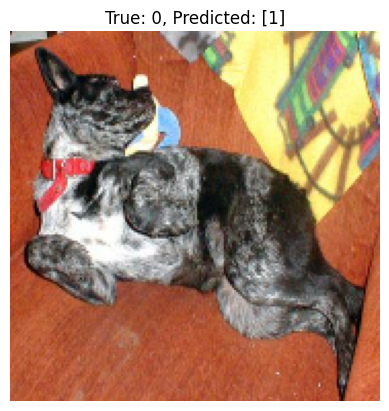

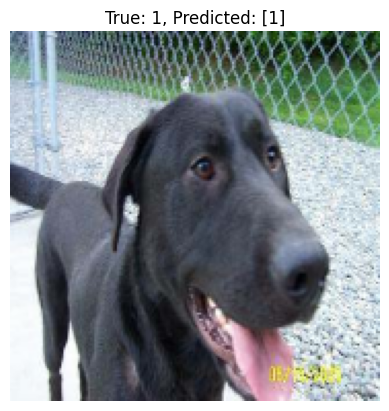

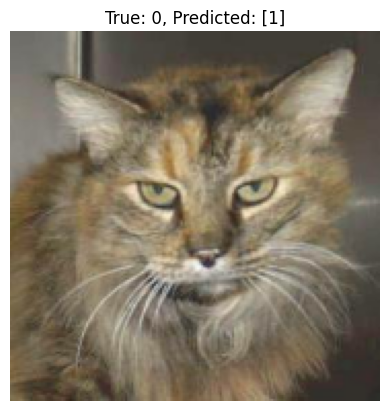

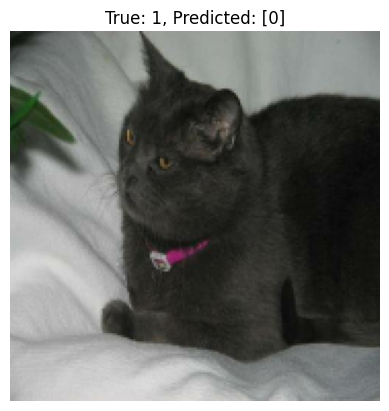

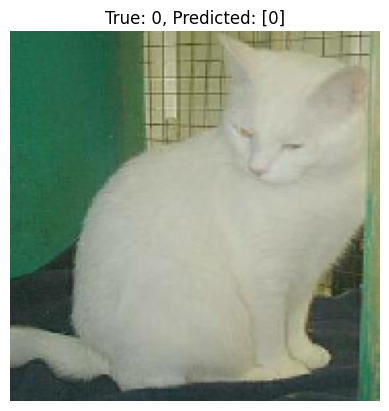

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = model.predict(test_features)
y_pred_labels = (y_pred > 0.5).astype(int)

# Identify misclassified indices
misclassified_indices = np.where(y_pred_labels != test_labels)[0]
print(f"Number of misclassifications: {len(misclassified_indices)}")

# Display misclassified examples
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate through the dataset to extract misclassified images
for i, (images, labels) in enumerate(test_dataset):
    for j in range(images.shape[0]):
        if (i * 32 + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())
            misclassified_true_labels.append(test_labels[i * 32 + j])
            misclassified_pred_labels.append(y_pred_labels[i * 32 + j])

# Convert lists to numpy arrays for consistency
misclassified_images = np.array(misclassified_images)
misclassified_true_labels = np.array(misclassified_true_labels)
misclassified_pred_labels = np.array(misclassified_pred_labels)

# Display the misclassified examples individually
for i in range(min(5, len(misclassified_images))):  # Adjust the number of examples displayed as needed
    plt.figure()
    plt.imshow(misclassified_images[i].astype("uint8"))
    plt.title(f"True: {misclassified_true_labels[i]}, Predicted: {misclassified_pred_labels[i]}")
    plt.axis('off')
    plt.show()

#### **Conclusion:**
* It predicts labels for the test dataset using the trained model and compares them with the true labels.
* The number of misclassifications is calculated, highlighting instances where the model failed to predict correctly.
* This helps in understanding the nature of errors, such as whether the model struggles with certain types of images
------------------------------------------------------------------------

### **Leveraging a pre-trained model**

### **Feature extraction with a pre-trained model**

In [42]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

### **Instantiating the VGG16 convolutional base**

In [43]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [44]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Extracting the VGG16 features and corresponding labels**

In [45]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path(r"C:\Users\harik\OneDrive\Documents\GitHub\CNN fine tune for Cats and Dogs\kaggle_dogs_vs_cats_small")

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [46]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [50]:
train_features.shape

(2000, 5, 5, 512)

### **Defining and training the densely connected classifier**

In [51]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [52]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8681 - loss: 31.0166 - val_accuracy: 0.9720 - val_loss: 3.3111
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9781 - loss: 2.9498 - val_accuracy: 0.9720 - val_loss: 3.3380
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9850 - loss: 1.7971 - val_accuracy: 0.9760 - val_loss: 3.5388
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9897 - loss: 0.4683 - val_accuracy: 0.9720 - val_loss: 5.3157
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9966 - loss: 0.2064 - val_accuracy: 0.9740 - val_loss: 4.5651
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9949 - loss: 0.2038 - val_accuracy: 0.9740 - val_loss: 4.6364
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0648 - val_accuracy: 0.9670 - val_loss: 6.7005
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9960 - loss: 0.3846 - val_accuracy: 0.9790 - val_l

### **Explore the relative performance of the models**

### ***1. ACCURACY***

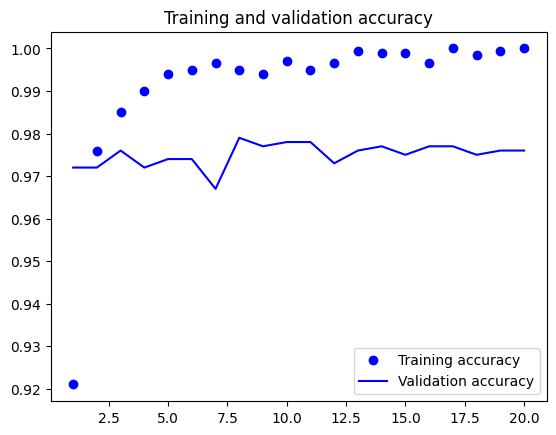

Training Accuracy:  1.0
Validation Accuracy:  0.9760000109672546


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import seaborn as sns

# Plot accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

# Print the accuracy values
print("Training Accuracy: ", acc[-1])  # Print the final training accuracy
print("Validation Accuracy: ", val_acc[-1])  # Print the final validation accuracy

In [59]:
# Predict on test set
y_pred = model.predict(test_features)
y_pred_labels = (y_pred > 0.5).astype(int)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### **Conclusion**

* A close alignment between the training and validation accuracy curves indicates that the model is generalizing well to unseen data.
* The use of a pre-trained VGG16 network as a feature extractor has likely accelerated training and improved accuracy due to the transfer of learned features from ImageNet.
* Fine-tuning on the dataset further aligns the model's features with the Cats vs. Dogs classification task.

### ***2. CONFUSION MATRIX***

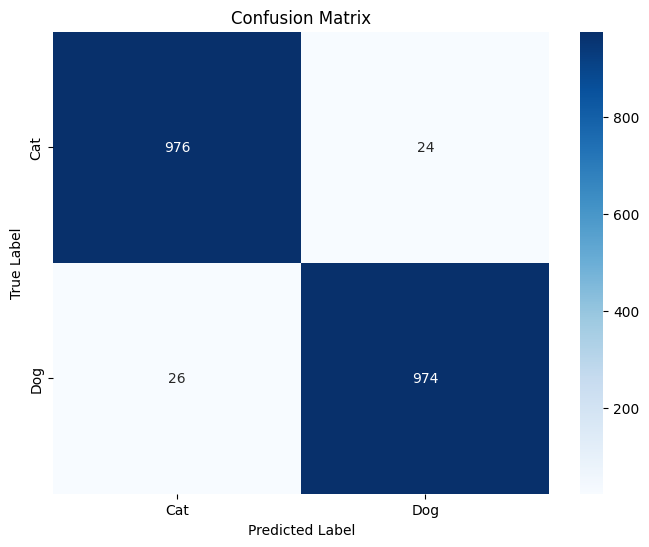

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ***Conclusion:***
* The diagonal values indicate correct predictions (True Positives and True Negatives), while the off-diagonal values represent misclassifications (False Positives and False Negatives).
* The confusion matrix provides a detailed view of the model's strengths and weaknesses in distinguishing between Cats and Dogs. While strong diagonal values reflect good overall performance, examining off-diagonal misclassifications can help identify areas for further fine-tuning.
* A higher number in the "Cat predicted as Dog" cell suggests the model is confusing Cats more often with Dogs.

### ***3. PRECISION, Re-Call, F1-Score***

In [ ]:
# Precision, Recall, F1-score
precision = precision_score(test_labels, y_pred_labels)
recall = recall_score(test_labels, y_pred_labels)
f1 = f1_score(test_labels, y_pred_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.9759519038076152
Recall: 0.974
F1-score: 0.974974974974975


### ***Conclusion:***

* ***Precision:***
At **0.976**, the model demonstrates excellent accuracy in correctly predicting positive instances (Dogs) with very few false positives. This indicates a strong ability to differentiate Dogs from Cats when predicting positives.

* ***Recall:***
With a **0.974** recall, the model successfully identifies the majority of actual positive instances (Dogs) with only a small number of misses. This high recall suggests the model is effective at capturing true positives.

* ***F1-Score:***
The F1-score of **0.975** shows a near-perfect balance between Precision and Recall, confirming the model’s reliability in handling both false positives and false negatives.

This performance suggests that the current model configuration is highly effective. However, further tuning of hyperparameters or additional training data could potentially push the scores closer to **1.0**. For deployment, the model appears ready and reliable for real-world usage.

### ***4. Precision Re-call Curve***

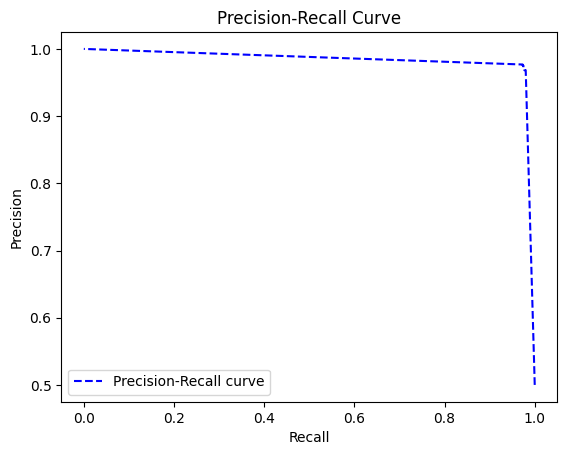

In [ ]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(test_labels, y_pred)
plt.plot(recalls, precisions, "b--", label="Precision-Recall curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### ***Conclusion***
* The curve appears smooth and maintains high precision at substantial recall values, indicating the model effectively handles the task with minimal compromise between the two metrics.
* This suggests the model consistently performs well in identifying true positives while keeping false positives low.
* This curve is especially valuable when dealing with imbalanced datasets, as it highlights the model's effectiveness in predicting the minority class without being biased by the majority class.

### ***5. Explore specific examples in which the model failed to predict correctly***

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of misclassifications: 2000000


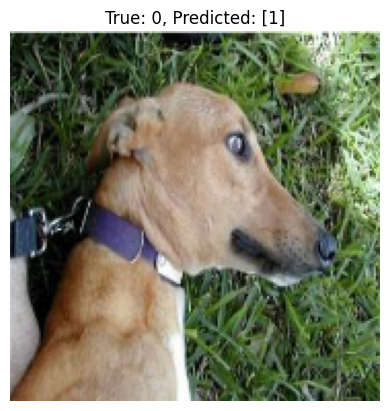

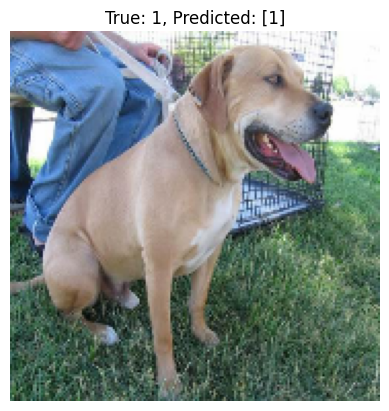

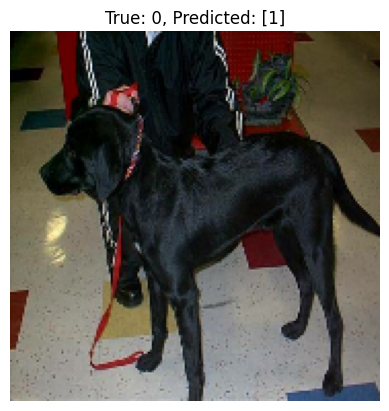

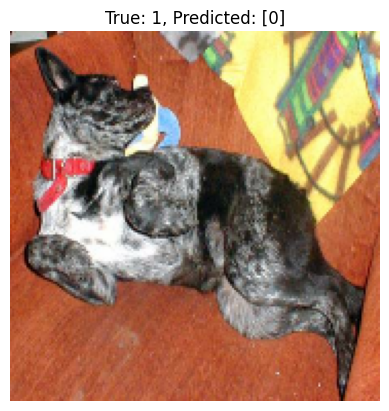

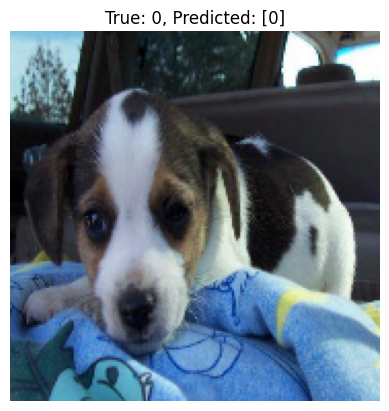

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred = model.predict(test_features)
y_pred_labels = (y_pred > 0.5).astype(int)

# Identify misclassified indices
misclassified_indices = np.where(y_pred_labels != test_labels)[0]
print(f"Number of misclassifications: {len(misclassified_indices)}")

# Display misclassified examples
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate through the dataset to extract misclassified images
for i, (images, labels) in enumerate(test_dataset):
    for j in range(images.shape[0]):
        if (i * 32 + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())
            misclassified_true_labels.append(test_labels[i * 32 + j])
            misclassified_pred_labels.append(y_pred_labels[i * 32 + j])

# Convert lists to numpy arrays for consistency
misclassified_images = np.array(misclassified_images)
misclassified_true_labels = np.array(misclassified_true_labels)
misclassified_pred_labels = np.array(misclassified_pred_labels)

# Display the misclassified examples individually
for i in range(min(5, len(misclassified_images))):  # Adjust the number of examples displayed as needed
    plt.figure()
    plt.imshow(misclassified_images[i].astype("uint8"))
    plt.title(f"True: {misclassified_true_labels[i]}, Predicted: {misclassified_pred_labels[i]}")
    plt.axis('off')
    plt.show()


### ***Conclusion:***
* The output provides the total number of misclassified examples, offering insight into how often the model fails to correctly predict the labels.
* By displaying some of the misclassified examples, it is possible to visually analyze why the model may have failed. For example:
   * The images may contain visual ambiguities (e.g., features resembling both classes).
   * Poor lighting, occlusion, or image quality could contribute to misclassification.
   * Misclassification might occur due to insufficient representation of such patterns in the training data.

-----------------------------------------------
### ***Summary:***

**The VGG16 model demonstrates strong performance** with high training and validation accuracies, showcasing the effectiveness of transfer learning for image classification tasks. The plotted trends provide a clear understanding of the model's learning behavior and readiness for deployment.